In [1]:
import numpy as np
import json
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import sys
import collections
import torch
from toytask_utils import make_tasks, all_divisions
from divergence_utils import SymmetricDefiniteMatrix
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

csv_id = None

# Generate Initial Data

In [17]:
n_samples = 100 # number of times to resample each class
x_values = [-0.45,0.45] # valid causal x values
y_values = [i for i in range(1)] # valid causal y values
std = 0.1 # standard deviation of noise along causal dims
cov = 0 # covariance between causal dims

varbs = []
for x in x_values:
    for y in y_values:
        varbs.append([(x>0)-(x<0),y])
varbs = np.asarray(varbs)

samples = []
og_varbs = []
xmean = 0
ymean = 0
for _ in range(n_samples):
    samp = varbs.copy().astype(float)
    og_varbs.append(varbs.copy())
    samp[:,0] += cov*samp[:,1]
    noise = std*np.random.randn(*samp.shape)
    samp = samp + noise
    samples.append(samp)
samples = np.vstack(samples)
samples = samples - samples.mean(0)
og_varbs = np.vstack(og_varbs)
print(samples.shape)

(200, 2)


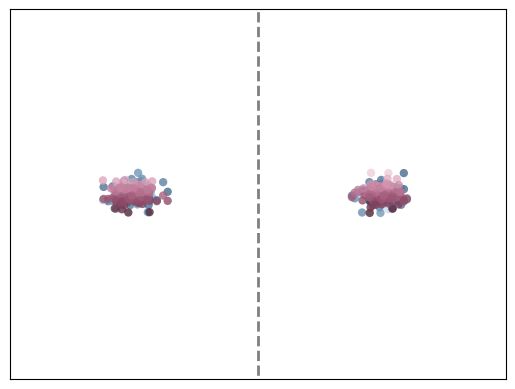

In [18]:
df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])


fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
thickness = 2
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
ax.plot([0,0],[-3,3], "k--", alpha=0.5, linewidth=thickness)
# x dividers
for i in y_values[:-1]:
    y = i+0.5-2
    ax.plot([-2,2],[y,y], "k--", alpha=0.5, linewidth=thickness)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
#native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
#intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

#ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
plt.legend().set_visible(False)
#plt.savefig("figs/example_divergence.png", dpi=600, bbox_inches="tight")

plt.show()

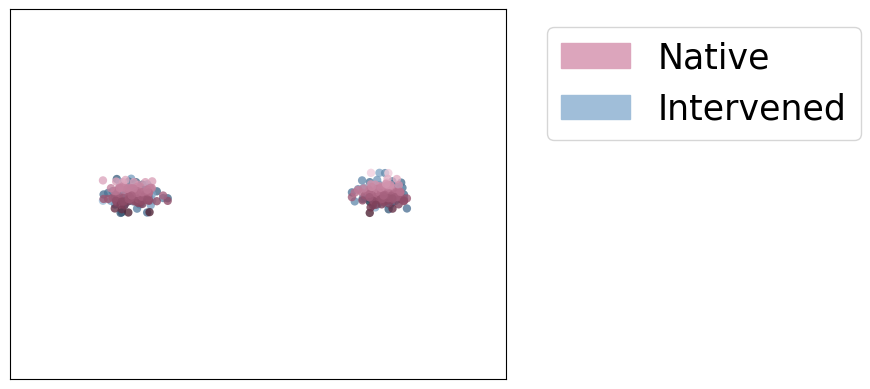

In [19]:
import matplotlib.patches as mpatches
import matplotlib as mpl

df = pd.DataFrame({
    "x": samples[:,0],
    "y": samples[:,1],
    "hue": samples[:,1],
})
df["x"] = (df["x"]-np.mean(df["x"]))
df["hue"] = df["hue"]-np.min(df["hue"])
df["hue"] = df["hue"]/np.max(df["hue"])



fontsize=25
legendsize = 25
alpha = 0.8
dark = 0.2
light = 0.85
rot = 0
fig = plt.figure()
ax = plt.gca()

intrv_df = df.copy()
intrv_df["y"] = np.asarray(intrv_df["y"])[np.random.permutation(len(intrv_df)).astype(int)]
intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#intrv_cmap = sns.dark_palette("blue", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=intrv_df, ax=ax, hue="hue", palette=intrv_cmap, edgecolor="none")

native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
#native_cmap = sns.dark_palette("red", as_cmap=True)
sns.scatterplot(x="x", y="y", alpha=alpha, data=df, ax=ax, hue="hue", palette=native_cmap, edgecolor="none")
                #hue="hue", palette="blue")
    
## y divider
#ax.plot([0,0],[-1,5], "k--", alpha=0.5)
## x dividers
#for i in y_values[:-1]:
#    y = i+0.5
#    ax.plot([-2,2],[y,y], "k--", alpha=0.5)
plt.xlim([-2,2])
plt.ylim([-2.75,2.75])

plt.xlabel("", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)

plt.xticks([], fontsize=fontsize)
plt.yticks([], fontsize=fontsize)

# # Manually create colorbars / legend patches
# native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
# intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)

# Legend handles: colored rectangles with labels
native_patch = mpatches.Patch(color=native_cmap(0.8), label="Native")
intrv_patch = mpatches.Patch(color=intrv_cmap(0.8), label="Intervened")

ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
#plt.savefig("figs/legend.png", dpi=600, bbox_inches="tight")

plt.show()

In [20]:
from geomloss import SamplesLoss
kwargs = {
    "loss": "sinkhorn",
    "p": 2,
    "blur": 0.05,
}
loss_fn = SamplesLoss(**kwargs)

def compute_emd(X,Y):
    return loss_fn(X.float(),Y.float())


# CL Loss

In [21]:
print(og_varbs.shape)
print(samples.shape)

(200, 2)
(200, 2)


In [22]:
def quick_plot(
    natty,
    intrv,
    natty_classes=None,
    intrv_classes=None,
    save_name=None,
    incl_legend=False,
    incl_dividers=True,
    xlim=[-2,2],
    ylim=[-2.75,2.75],
    incl_ticks=False,
    labels=["Native", "Intervened"],
    intrv_cmap=None,
    native_cmap=None,
    intrv_color=None,
    native_color=None,
    intrv_alpha = 0.95,
    native_alpha = 0.6,
    thickness=2,
    dash_alpha=0.5,
    legendsize = 25,
    dark = 0.2,
    light = 0.85,
    rot = 0,
    y_values=[i+0.5-2 for i in range(5)],
):
    fig = plt.figure()
    ax = plt.gca()
    
    if not incl_ticks:
        plt.xticks([])
        plt.yticks([])
    
    natty = natty.cpu().detach().numpy()
    intrv = intrv.cpu().detach().numpy()
    
    if natty_classes is None:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    elif len(set(intrv_classes))==1:
        if intrv_cmap is None:
            intrv_cmap = sns.cubehelix_palette(start=-.3, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if intrv_color is None:
            intrv_color = intrv_cmap(0.8)
        sns.scatterplot(x=intrv[:,0], y=intrv[:,1], alpha=intrv_alpha, ax=ax, color=intrv_color, edgecolor="none")
    else:
        if intrv_cmap is None:
            intrv_cmap = sns.color_palette("pastel")
        sns.scatterplot(
            x=intrv[:,0], y=intrv[:,1],
            alpha=intrv_alpha, ax=ax,
            hue=intrv_classes, palette=intrv_cmap
        )

    if natty_classes is None:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    elif len(set(natty_classes))==1:
        if native_cmap is None:
            native_cmap = sns.cubehelix_palette(start=0.7, rot=rot, dark=dark, light=light, reverse=True, as_cmap=True)
        if native_color is None:
            native_color = native_cmap(0.8)
        sns.scatterplot(x=natty[:,0], y=natty[:,1], alpha=native_alpha, ax=ax, color=native_color, edgecolor="none")
    else:
        if native_cmap is None:
            native_cmap = sns.color_palette("dark")
        sns.scatterplot(
            x=natty[:,0],
            y=natty[:,1],
            alpha=native_alpha,
            ax=ax,
            hue=natty_classes,
            palette=native_cmap,
            edgecolor="none"
        )
        
    if incl_legend and natty_classes is None:
        native_patch = mpatches.Patch(color=native_color, label=labels[0])
        intrv_patch = mpatches.Patch(color=intrv_color, label=labels[1])
        ax.legend(handles=[native_patch, intrv_patch], fontsize=legendsize, loc="upper right", bbox_to_anchor=(1.75,1))
    elif incl_legend:
        plt.legend()
    else:
        plt.legend().set_visible(False)
        
    ## y divider
    if incl_dividers:
        ax.plot([0,0],[-3,3], "k--", linewidth=thickness, alpha=dash_alpha)
        # x dividers
        for y in y_values[:-1]:
            ax.plot([-2,2],[y,y], "k--", linewidth=thickness, alpha=dash_alpha)
    plt.xlim(xlim)
    plt.ylim(ylim)
    if save_name:
        plt.savefig(save_name, dpi=600, bbox_inches="tight")
    plt.show()    

In [23]:
def rot_fwd(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    return torch.matmul(vecs, mtx.weight ).float()

def rot_bck(vecs, mtx):
    mdtype = next(mtx.parameters()).dtype
    if mdtype!=vecs.dtype:
        vecs = vecs.double()
    inv = torch.linalg.inv(mtx.weight)
    return torch.matmul(vecs, inv ).float()

def interchange(trg,src,mtx,mask):
    """
    Patches the non-zero masked values from the src
    into the trg vectors in the rotated space.
    
    Args:
        trg: torch tensor (B,D)
        src: torch tensor (B,D)
        mtx: torch module (D,D)
            needs "weight" property
        mask: torch tensor (D,)
            ones denote dimensions that will be transferred
    """
    rot_trg = rot_fwd(trg, mtx)
    rot_src = rot_fwd(src, mtx)
    intrv = rot_trg*(1-mask) + rot_src*mask
    return rot_bck(intrv, mtx)

In [24]:
def normalize_fn(vecs, eps=1e-7):
    return (vecs-vecs.mean(0))/(vecs.std(0)+eps)

In [25]:
def get_classes_from_varbs(varbs, v2class=None):
    if v2class is None:
        v2class = dict()
    classes = []
    for v in varbs.detach().cpu().tolist():
        tup = tuple(v)
        if tup not in v2class:
            v2class[tup] = len(v2class)
        classes.append(v2class[tup])
    return np.asarray(classes), v2class
    

/tmp/ipykernel_2175867/2221184772.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  og_varbs = torch.tensor(og_varbs).long()
/tmp/ipykernel_2175867/2221184772.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples).float()
/tmp/ipykernel_2175867/2286931381.py:52: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


Samps: 39800
Classes: 39800


/tmp/ipykernel_2175867/2286931381.py:73: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


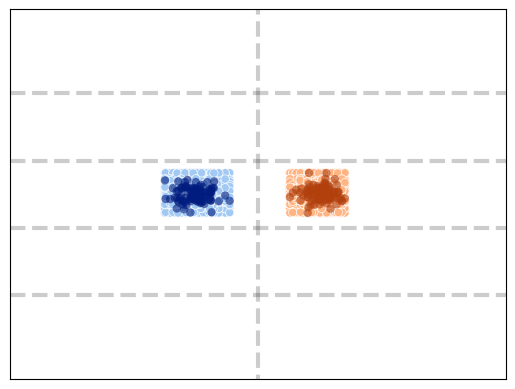

/tmp/ipykernel_2175867/2286931381.py:52: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_2175867/2286931381.py:73: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


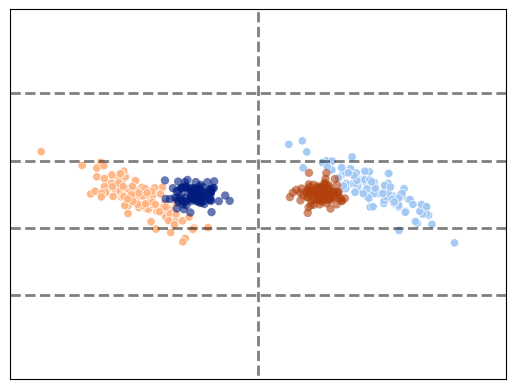

In [31]:
extra_dims = 64
cov = 0
mask_dims = 1

og_varbs = torch.tensor(og_varbs).long()
d = og_varbs.shape[-1] + extra_dims
mask = torch.zeros(d)
mask[:mask_dims] = 1

samples = torch.tensor(samples).float()
noise = torch.randn(len(og_varbs), extra_dims) + cov * torch.randn(len(og_varbs), extra_dims)*og_varbs[:,1:]
natty_varbs = og_varbs.clone()
natty_classes, v2class = get_classes_from_varbs(natty_varbs)
natty_classes = (natty_varbs[:,0]>0).float()
natty_samps = torch.cat([ samples, noise ], dim=-1)
perm = torch.randperm(len(og_varbs)).long()


eye = torch.nn.Linear(d,d)
eye.weight.data = torch.eye(d).float()
intrv_list = []
class_list = []
for i in range(1,len(natty_samps)):
    trg_vecs = torch.roll(natty_samps.clone(), i, dims=0)
    src_vecs = natty_samps.clone()
    
    intrv_varbs = torch.cat([ natty_varbs[:,0:1], torch.roll(natty_varbs[:,1:],i, dims=0) ], dim=-1)
    intrv_classes = (natty_varbs[:,0]>0).float()

    with torch.no_grad():
        intrv_samps = interchange(trg_vecs, src_vecs, eye, mask)
    intrv_list.append(intrv_samps)
    class_list.append(intrv_classes)
intrv_samps = torch.cat(intrv_list)
intrv_classes = np.concatenate(class_list)
print("Samps:", len(intrv_samps))
print("Classes:", len(intrv_classes))

intrv_samps[:,0] = intrv_samps[:,0] - torch.sign(intrv_samps[:,0])*0.5
natty_samps[:,0] = natty_samps[:,0] - torch.sign(natty_samps[:,0])*0.5

# Sanity check
quick_plot(
    natty_samps,
    intrv_samps,
    natty_classes=natty_classes,
    intrv_classes=intrv_classes,
    dash_alpha=0.2,
    thickness=3,
    save_name="figs/sphereproof.png",
)

rot_mtx = torch.nn.utils.parametrizations.orthogonal(torch.nn.Linear(d,d))

with torch.no_grad():
    intrv_samps = interchange(trg_vecs, src_vecs, rot_mtx, mask)
    intrv_classes = (natty_varbs[:,0]>0).float()

# Sanity check
quick_plot(natty_samps, intrv_samps, natty_classes=natty_classes, intrv_classes=intrv_classes)
